# Extracting data from MISP using PyMISP

## Recovering the API KEY

- Go to `Global Actions` then `My Profile`
- Access the `/users/view/me` URL

In [1]:
from pymisp import PyMISP
import urllib3
urllib3.disable_warnings()

misp_url = 'https://training6.misp-community.org/'
misp_key = '_YOUR_AUTHENTICATION_KEY_'
# Should PyMISP verify the MISP certificate
misp_verifycert = False

misp = PyMISP(misp_url, misp_key, misp_verifycert)

In [2]:
import datetime
from pprint import pprint
import base64
import subprocess

## Retrieving an Event

In [3]:
r1 = misp.get_event('bce908c7-4b01-49ed-a9d3-6addfe8cf3f8', pythonify=True)
print(r1)
r2 = misp.get_event(54, pythonify=False)
print(type(r2))
print(r2['Event']['info'])

<MISPEvent(info=GRU Close Operation OCPW (NL))
<class 'dict'>
GRU Close Operation OCPW (NL)


## Searching the Event index

In [4]:
r = misp.search_index(pythonify=True)
print(r[1].info)

Successful Scammer Call


#### Only published Events

In [5]:
r = misp.search_index(published=True, pythonify=True)
print(r)
# print(r[0].to_dict())

[<MISPEvent(info=Successful scam call), <MISPEvent(info=Successful Scammer Call), <MISPEvent(info=Event created via the API as an example), <MISPEvent(info=Test Scam Call), <MISPEvent(info=Successful scam call), <MISPEvent(info=Handsome_Ransomware_1_2024_Lyon_69009), <MISPEvent(info=local event), <MISPEvent(info=Test distribution & sync), <MISPEvent(info=ddos in italy), <MISPEvent(info=Test), <MISPEvent(info=Test G1), <MISPEvent(info=ATM Vulnerabilities Allow Deposit Forgery Attacks), <MISPEvent(info=Dirty harry example), <MISPEvent(info=Kobalos - Linux threat to high performance computing infrastructure), <MISPEvent(info=Decaying example), <MISPEvent(info=Investigation Syrian Electronic Army Activities - Domain(s) Take over via Melbourne IT registrar), <MISPEvent(info=Spear-phishing attempt targeting telco sector), <MISPEvent(info=Test)]


#### Playing with time

**Multiple type of timestamps for Events**
- `timestamp`: Timestamp of the **last modification** of the Event or its content (include Attributes, Objects, Tags, ...)
- `published_timestamp`: Timestamp of the **last publication** of the Event
- To generate report, you usually want to use `publish_timestamp`

**Multiple type of dates for Events**
- `date_from`: Only events having a more recent date will be returned
- `date_to`: Only events having an older date will be returned
- Both can be used at once to specify a time window


In [6]:
# Using string literal
sinceLastMonth = '30d'
# Using Python's datetime
sinceLastMonth = datetime.date.today() - datetime.timedelta(days=30)

r = misp.search_index(published=True, publish_timestamp=sinceLastMonth, pythonify=True)
pprint(r)

[<MISPEvent(info=Event created via the API as an example),
 <MISPEvent(info=ddos in italy),
 <MISPEvent(info=Test),
 <MISPEvent(info=Test G1),
 <MISPEvent(info=ATM Vulnerabilities Allow Deposit Forgery Attacks),
 <MISPEvent(info=Dirty harry example),
 <MISPEvent(info=Kobalos - Linux threat to high performance computing infrastructure),
 <MISPEvent(info=Decaying example),
 <MISPEvent(info=Investigation Syrian Electronic Army Activities - Domain(s) Take over via Melbourne IT registrar),
 <MISPEvent(info=Spear-phishing attempt targeting telco sector),
 <MISPEvent(info=Test)]


#### Data returned
- Searching the index will only returns high-level information about the Event and its attached context

- Can be useful for:
    - Statistics about number of created Event
    - Statistics about Organisation creating Event over time
    - Statistics about distribution level usage
- And, **If Event correctly contextualized**
    - Statistics about **type of incident**
    - Adversary tactics and techniques with **MITRE ATT&CK** usage
    - Malware familly

In [7]:
event = r[4].to_dict()
event_properties = event.keys()
print('# Event properties')
print(list(event_properties))

print('\n # Event Tags ({0})'.format(len(event['EventTag'])))
pprint(event['EventTag'][0])

print('\n # Event Clusters ({0})'.format(len(event['GalaxyCluster'])))

# Event properties
['uuid', 'info', 'distribution', 'threat_level_id', 'analysis', 'published', 'date', 'id', 'orgc_id', 'org_id', 'timestamp', 'publish_timestamp', 'sighting_timestamp', 'sharing_group_id', 'Org', 'Orgc', 'attribute_count', 'proposal_email_lock', 'locked', 'disable_correlation', 'extends_uuid', 'GalaxyCluster', 'EventTag']

 # Event Tags (6)
{'Tag': {'colour': '#004646',
         'id': '51',
         'is_galaxy': False,
         'name': 'type:OSINT'},
 'event_id': '43',
 'id': '68',
 'local': False,
 'relationship_type': '',
 'tag_id': '51'}

 # Event Clusters (3)


#### Useful parameters

- `attribute` (Optional[str]) *Filter events on attribute's value*
- `published` (Optional[bool])
- `hasproposal` (Optional[bool])
- `eventid` (Optional[str, int])
- `tags` (Optional[str, List[str]])
- `date_from` (Optional[datetime, date, int, str, float, None])
- `date_to` (Optional[datetime, date, int, str, float, None])
- `eventinfo` (Optional[str])
- `threatlevel` (Optional[str, int])
- `analysis` (Optional[str, int])
- `distribution` (Optional[str, int])
- `sharinggroup` (Optional[str, int])
- `org` (Optional[str, List[[str, int]])
- `timestamp` (Optional[datetime, date, int, str, float, None, List[[datetime, date, int, str, float, None], [datetime, date, int, str, float, None]]])
    - timestamp=(datetime.today() - timedelta(days=1))
    - timestamp=['14d', '7d']
    - timestamp=int(datetime.today().timestamp())
- `publish_timestamp` (Optional[datetime, date, int, str, float, None, List[[datetime, date, int, str, float, None], [datetime, date, int, str, float, None]]])

## Retrieving data with RestSearch

The `RestSearch` endpoint can be used on multiple scopes. It has more filtering parameters and is generally flexible.

Supported scopes (also called Controllers): `events`, `attributes`, `objects`

### `/events/restSearch` VS `/attributes/restSearch`

- Both endpoints support most of the parameter
- They differs in the data returned
    - `/events/restSearch` returns the whole Event with its child elements (Attributes, Objects, Proposals, ..)
    - `/attributes/restSearch` returns all attributes

#### Getting only metadata: Do not include child elements (such as Attributes, ...)

In [8]:
r = misp.search(controller='events', metadata=True, pythonify=True)
pprint(r)

[<MISPEvent(info=Successful scam call),
 <MISPEvent(info=Successful Scammer Call),
 <MISPEvent(info=Event created via the API as an example),
 <MISPEvent(info=Event created via the API as an example),
 <MISPEvent(info=Test Scam Call),
 <MISPEvent(info=Successful scam call),
 <MISPEvent(info=Ataque DDoS Paginas WEB7),
 <MISPEvent(info=Handsome_Ransomware_1_2024_Lyon_69009),
 <MISPEvent(info=local event),
 <MISPEvent(info=Test distribution & sync),
 <MISPEvent(info=ddos in italy),
 <MISPEvent(info=Test),
 <MISPEvent(info=Test G1),
 <MISPEvent(info=ATM Vulnerabilities Allow Deposit Forgery Attacks),
 <MISPEvent(info=Dirty harry example),
 <MISPEvent(info=Kobalos - Linux threat to high performance computing infrastructure),
 <MISPEvent(info=Decaying example),
 <MISPEvent(info=Investigation Syrian Electronic Army Activities - Domain(s) Take over via Melbourne IT registrar),
 <MISPEvent(info=Spear-phishing attempt targeting telco sector),
 <MISPEvent(info=Targeted phishing - PDF documents / 

### Searching Attributes with RestSearch

#### Searching for values

In [9]:
r1 = misp.search(controller='attributes', value='8.8.8.8', pythonify=True)
print('Simple value:', r1)

r2 = misp.search(controller='attributes', value=['8.8.8.8', '5.4.2.1'], pythonify=True)
print('List of values:', r2)

r3 = misp.search(controller='attributes', value=['9.9.%.%'], pythonify=True)
print('Wildcard:', r3)

Simple value: [<MISPAttribute(type=ip-src, value=8.8.8.8), <MISPAttribute(type=ip-dst, value=8.8.8.8), <MISPAttribute(type=ip-dst, value=8.8.8.8), <MISPAttribute(type=ip-src, value=8.8.8.8), <MISPAttribute(type=ip-src, value=8.8.8.8), <MISPAttribute(type=ip-dst, value=8.8.8.8)]
List of values: [<MISPAttribute(type=ip-src, value=8.8.8.8), <MISPAttribute(type=ip-dst, value=8.8.8.8), <MISPAttribute(type=ip-dst, value=8.8.8.8), <MISPAttribute(type=ip-src, value=8.8.8.8), <MISPAttribute(type=ip-src, value=8.8.8.8), <MISPAttribute(type=ip-dst, value=8.8.8.8)]
Wildcard: [<MISPAttribute(type=ip-src, value=9.9.9.9)]


#### Searching for types

In [10]:
r1 = misp.search(controller='attributes', type_attribute='first-name', pythonify=True)
pprint(r1)

r2 = misp.search(controller='attributes', type_attribute=['malware-sample', 'attachment'], pythonify=True)
pprint(r2)

[<MISPAttribute(type=first-name, value=Harry),
 <MISPAttribute(type=first-name, value=Jennifer),
 <MISPAttribute(type=first-name, value=Samantha),
 <MISPAttribute(type=first-name, value=John),
 <MISPAttribute(type=first-name, value=John),
 <MISPAttribute(type=first-name, value=russe 1)]
[<MISPAttribute(type=attachment, value=DirtyHarry.jpg),
 <MISPAttribute(type=attachment, value=sunny.png),
 <MISPAttribute(type=attachment, value=jennifer-spencer.png),
 <MISPAttribute(type=attachment, value=samantha.png),
 <MISPAttribute(type=attachment, value=DirtyHarry-Car.jpg),
 <MISPAttribute(type=attachment, value=Figure-2.-Overview-of-Kobalos-features-and-ways-to-access-them.png),
 <MISPAttribute(type=attachment, value=Figure-4.-Sequence-diagram-summarizing-Kobalos-network-protocols.png),
 <MISPAttribute(type=attachment, value=syrian-conflict-spills-into-cyberspace-2013.pdf),
 <MISPAttribute(type=attachment, value=sea-1.png),
 <MISPAttribute(type=attachment, value=sea-2.png),
 <MISPAttribute(type

#### Searching for tags

`includeEventTags` is an optional field on Attributes to also include the tags at event level. 

In [11]:
r1 = misp.search(controller='attributes', tags='tlp:red', includeEventTags=True, pythonify=True)
print(r1)
print('\tFirst Attribute Tag', r1[1].Tag)
r2 = misp.search(controller='attributes', tags=['tlp:red'], pythonify=True)
print(r2)
print('\tFirst Attribute Tag', r2[1].Tag)

[<MISPAttribute(type=ip-dst, value=127.1.1.1), <MISPAttribute(type=ip-dst, value=8.8.8.9), <MISPAttribute(type=text, value=post), <MISPAttribute(type=email-dst, value=jatboss6@gmail.com), <MISPAttribute(type=first-name, value=russe 1), <MISPAttribute(type=ip-src, value=9.9.9.9)]
	First Attribute Tag [<MISPTag(name=tlp:red)>, <MISPTag(name=tlp:green)>]
[<MISPAttribute(type=ip-dst, value=127.1.1.1), <MISPAttribute(type=ip-dst, value=8.8.8.9), <MISPAttribute(type=text, value=post), <MISPAttribute(type=email-dst, value=jatboss6@gmail.com), <MISPAttribute(type=first-name, value=russe 1), <MISPAttribute(type=ip-src, value=9.9.9.9)]
	First Attribute Tag []


**Complex query**

In [13]:
complex_query = misp.build_complex_query(or_parameters=['tlp:amber', 'adversary:infrastructure-type="c2"'])
r7 = misp.search(
    controller='attributes',
    tags=complex_query,
    includeEventTags=True,
    pythonify=True)
print('Or:', len(r7))
pprint([
    [tag.name for tag in attr.Tag if (tag.name == 'tlp:amber' or tag.name == 'adversary:infrastructure-type="c2"')] for attr in r7[:5]
])
print()

complex_query = misp.build_complex_query(and_parameters=['tlp:amber', 'adversary:infrastructure-type="c2"'])
r8 = misp.search(
    controller='attributes',
    tags=complex_query,
    includeEventTags=True,
    pythonify=True)
print('And:', len(r8))
pprint([
    [tag.name for tag in attr.Tag if (tag.name == 'tlp:amber' or tag.name == 'adversary:infrastructure-type="c2"')] for attr in r8
])

Or: 56
[['tlp:amber'], ['tlp:amber'], ['tlp:amber'], ['tlp:amber'], ['tlp:amber']]

And: 0
[]


#### Searching on GalaxyCluster metadata

In [14]:
body = {
    'galaxy.member-of': 'NATO',
    'galaxy.official-languages': 'French',
}

events = misp.direct_call('/events/restSearch', body)
print('Events: ', len(events))
for event in events:
    print('event', event['Event']['id'], 'has', len(event['Event'].get('Tag', [])), 'tag(s)')

Events:  30
event 28 has 5 tag(s)
event 29 has 6 tag(s)
event 30 has 0 tag(s)
event 31 has 2 tag(s)
event 32 has 21 tag(s)
event 33 has 5 tag(s)
event 34 has 0 tag(s)
event 37 has 3 tag(s)
event 38 has 0 tag(s)
event 39 has 0 tag(s)
event 40 has 5 tag(s)
event 41 has 0 tag(s)
event 42 has 0 tag(s)
event 43 has 6 tag(s)
event 44 has 0 tag(s)
event 45 has 23 tag(s)
event 46 has 2 tag(s)
event 47 has 4 tag(s)
event 48 has 11 tag(s)
event 49 has 9 tag(s)
event 50 has 0 tag(s)
event 51 has 1 tag(s)
event 52 has 2 tag(s)
event 53 has 0 tag(s)
event 54 has 3 tag(s)
event 55 has 2 tag(s)
event 56 has 3 tag(s)
event 57 has 4 tag(s)
event 58 has 1 tag(s)
event 59 has 1 tag(s)


- **Note 1**: The `galaxy.*` instructions are not supported by PyMISP
- **Note 2**: Each `galaxy.*` instructions are **AND**ed and are applied for the same cluster
    - Cannot combine from different clusters
    - Combining `Galaxy.official-languages` and `Galaxy.synonyms` would likely gives no result

#### Searching on creator Organisation metadata

In [15]:
all_orgs = misp.organisations()
print('Organisation nationality:', {org['Organisation']['name']: org['Organisation']['nationality'] for org in all_orgs})

body = {
    'org.name': 'CIRCL'
}

events = misp.direct_call('/events/restSearch', body)
print('Events: ', len(events))
print('Org for each Event:', [event['Event']['Orgc']['name'] for event in events])

Organisation nationality: {'CIRCL': '', 'ORG_1': '', 'ORG_2': '', 'ORG_3': '', 'ORG_4': '', 'ORG_5': '', 'ORG_6': '', 'ORG_Demo': '', 'ORG_Main': '', 'ORGNAME': ''}
Events:  30
Org for each Event: ['ORGNAME_7544', 'ORG_Main', 'ORGNAME_7544', 'ORG_6', 'ORG_Main', 'ORG_Main', 'ORG_Main', 'ORG_Main', 'ADMIN', 'ORGNAME_7544', 'ORG_Main', 'ADMIN_6098', 'ADMIN_6098', 'CIRCL', 'CIRCL', 'ORGNAME_7157', 'Training', 'CIRCL', 'Training', 'EUROLEA', 'CIRCL', 'CIRCL', 'CIRCL', 'ORG_6', 'CIRCL', 'ORG_6', 'ORG_6', 'ORG_6', 'ORG_6', 'CIRCL']


- **Note 1**: The `org.*` instructions are not supported by PyMISP

#### ReturnFormat

**CSV**

In [16]:
r1 = misp.search(
    controller='attributes',
    type_attribute=['ip-src', 'ip-dst'],
    limit=10, page=1,
    return_format='csv')
print(r1)

uuid,event_id,category,type,value,comment,to_ids,date,object_relation,attribute_tag,object_uuid,object_name,object_meta_category
"0bf65f60-d43f-4fde-8601-2fb45616e153",31,"Network activity","ip-dst","127.1.1.1","Comment added via the API",0,1728029326,"","","","",""
"b3eedfc4-8ffa-41a2-875b-6c3d0e4602b8",31,"Network activity","ip-dst","8.8.8.9","",1,1728029303,"","","","",""
"b68a0708-f851-4997-90a1-80847d1a4b8e",32,"Network activity","ip-dst","8.8.8.8","",0,1728394456,"","","","",""
"f52c63ce-fad1-47d3-b368-a461bf1fcee6",32,"Network activity","ip-dst","194.78.89.250","",1,1727861958,"ip","","","",""
"72bb7d16-61b3-4089-8a23-dd6d9d972f62",30,"Network activity","ip-dst","3.3.3.3","",0,1728285118,"","","","",""
"1fc09433-0a46-4f29-87fc-ad7c46956d14",34,"Network activity","ip-dst","8.8.8.8","",1,1730210550,"","","","",""
"d2c99598-5caa-4e70-81d8-a0d6e3074ef2",40,"Network activity","ip-dst","81.126.77.60","",1,1734337516,"ip","","","",""
"c8043d80-79f7-4a49-a3a8-138b5ad58bc9",41,"Network a

**Aggregated context** with `context-markdown`, `context` and `attack`

In [17]:
# Get the context of Events that were created by organisations from the financial sector

body = {
    'returnFormat': 'context-markdown',
    'org.sector': ['financial'],
}

r2 = misp.direct_call('/events/restSearch', body)
print(r2)

# Aggregated context data
## Tags and Taxonomies

## Galaxy Clusters



#### Be carefull with the amount of data you ask, use `pagination` if needed

- `limit`: Specify the amount of data to be returned
- `page`: Specify the start of the rolling window. Is **not** zero-indexed

If the size of the returned data is larger than the memory enveloppe you might get a different behavior based on your MISP setting:
- Nothing returned. Allowed memeory by PHP process exausted
- Data returned but slow. MISP will concatenante the returned data in a temporary file on disk
    - This behavior is only applicable for `/*/restSearch` endpoints

In [18]:
r1 = misp.search(controller='attributes', pythonify=True)
print('Amount of Attributes', len(r1))

r2 = misp.search(
    controller='attributes',
    page=1,
    limit=5,
    pythonify=True)
print('Amount of paginated Attributes', len(r2))

Amount of Attributes 3855
Amount of paginated Attributes 5


## Searching for Sightings

In [19]:
body = {
    'last': '7d'
}

sightings = misp.direct_call('/sightings/restSearch', body)
pprint(sightings)

[{'Sighting': {'Organisation': {'id': '8',
                                'name': 'ORG_6',
                                'uuid': '591c3fb6-4abe-4d47-b2ea-22e2299819e9'},
               'attribute_id': '199852',
               'date_sighting': '1736587574',
               'event_id': '49',
               'id': '16',
               'org_id': '8',
               'source': '',
               'type': '0',
               'uuid': 'c842d893-b08c-4dd2-bbb1-6a617cad19ad',
               'value': 'jatboss6@gmail.com'}},
 {'Sighting': {'Organisation': {'id': '8',
                                'name': 'ORG_6',
                                'uuid': '591c3fb6-4abe-4d47-b2ea-22e2299819e9'},
               'attribute_id': '199852',
               'date_sighting': '1736587770',
               'event_id': '49',
               'id': '17',
               'org_id': '8',
               'source': '',
               'type': '0',
               'uuid': '1793567b-111b-4e4b-bb5a-209442579b43',
            

## Plotting data

#### Sightings over time

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# Converting our data to Panda DataFrame
sighting_rearranged = [sighting['Sighting'] for sighting in sightings]
df = pd.DataFrame.from_dict(sighting_rearranged)
df["date_sighting"] = pd.to_datetime(df["date_sighting"], unit='s')
df['one'] = 1
df

/var/folders/rs/1d27yk155l9bjh_91m6655tr0000gn/T/ipykernel_57586/2015836940.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["date_sighting"] = pd.to_datetime(df["date_sighting"], unit='s')


,id,attribute_id,event_id,org_id,date_sighting,uuid,source,type,value,Organisation,one
0,16,199852,49,8,2025-01-11 09:26:14,c842d893-b08c-4dd2-bbb1-6a617cad19ad,,0,jatboss6@gmail.com,"{'id': '8', 'uuid': '591c3fb6-4abe-4d47-b2ea-2...",1
1,17,199852,49,8,2025-01-11 09:29:30,1793567b-111b-4e4b-bb5a-209442579b43,,0,jatboss6@gmail.com,"{'id': '8', 'uuid': '591c3fb6-4abe-4d47-b2ea-2...",1
2,18,199852,49,13,2025-01-11 09:29:36,a1e4d774-6291-43b5-87b3-f7a263b033bc,,0,jatboss6@gmail.com,"{'id': '13', 'uuid': '55f6ea5e-2c60-40e5-964f-...",1
3,19,199852,49,8,2025-01-11 09:29:40,5dfe4cf0-e1a0-4b95-b1c5-652b373dda1f,,0,jatboss6@gmail.com,"{'id': '8', 'uuid': '591c3fb6-4abe-4d47-b2ea-2...",1
4,20,199852,49,8,2025-01-11 09:29:41,84fa0421-3d37-4c24-a6cc-58f3175cddd3,,1,jatboss6@gmail.com,"{'id': '8', 'uuid': '591c3fb6-4abe-4d47-b2ea-2...",1


In [22]:
print('Min and Max:', df['date_sighting'].min(), df['date_sighting'].max())
print('Time delta:', df['date_sighting'].max() - df['date_sighting'].min())
print('Unique Event IDs:', df.event_id.unique())

Min and Max: 2025-01-11 09:26:14 2025-01-11 09:29:41
Time delta: 0 days 00:03:27
Unique Event IDs: ['49']


attribute_id
199852    5
Name: count, dtype: int64


<Axes: xlabel='attribute_id'>

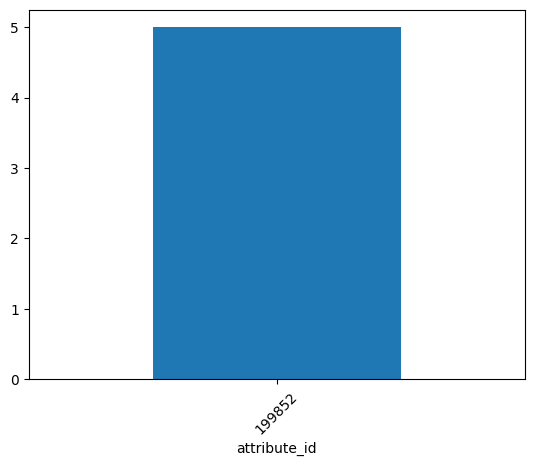

In [23]:
# Grouping by Attribute value
value_count = df['attribute_id'].value_counts()
print(value_count)
value_count.plot(kind='bar', rot=45)

date_sighting
5    5
Name: count, dtype: int64


<Axes: xlabel='date_sighting'>

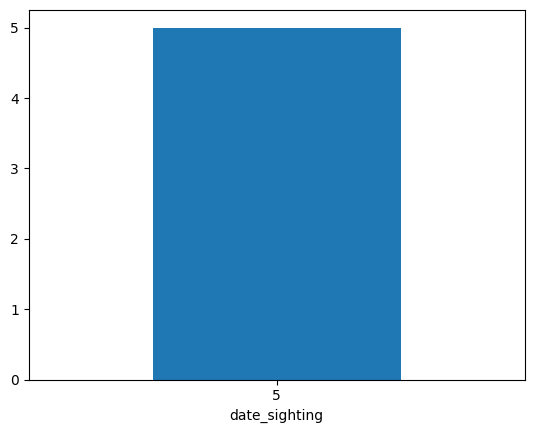

In [24]:
# Grouping by weekday (0-indexed)
amount_per_weekday = df['date_sighting'].dt.weekday.value_counts()
print(amount_per_weekday)
amount_per_weekday.plot(kind='bar', rot=0)

date_sighting
9    5
Name: one, dtype: int64


<Axes: xlabel='date_sighting'>

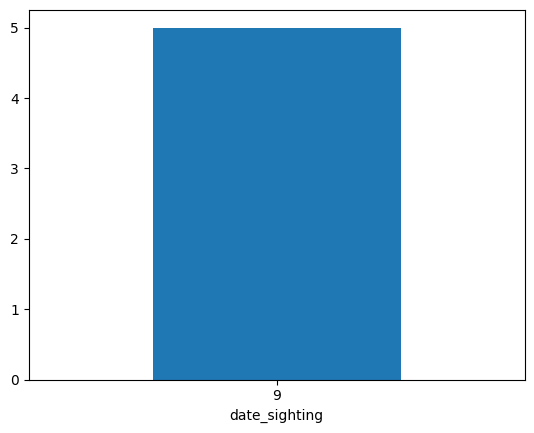

In [25]:
amount_per_weekday_for_each_attribute = df.groupby([df['date_sighting'].dt.hour])['one'].sum()
print(amount_per_weekday_for_each_attribute)
amount_per_weekday_for_each_attribute.plot(kind='bar', rot=0)